In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]

print(trigrams[:3])

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]


In [4]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

ix_to_word= {i:word for i, word in enumerate(vocab)}

In [5]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [6]:
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [7]:

for epoch in range(1000):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!

/home/demir/anaconda3/envs/pDL/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


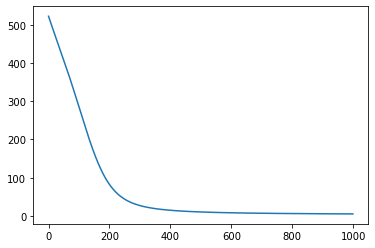

In [8]:
plt.plot(losses)

In [9]:
for context, target in trigrams:
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    log_probs = model(context_idxs)
    
    log_probs_numpy=log_probs.detach().numpy()
    print('Given:',context)
    print('Predicted word:',ix_to_word[np.argmax(log_probs_numpy)])
    print('Target:',target)
    break

Given: ['When', 'forty']
Predicted word: winters
Target: winters
